In [38]:
import os
from dotenv import load_dotenv

load_dotenv()

from datasets import load_dataset

ds = load_dataset("UTAustin-AIHealth/MedHallu", "pqa_labeled")

In [39]:
import goodfire
GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")
client = goodfire.Client(api_key=GOODFIRE_API_KEY)
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

In [40]:
df = ds['train'].to_pandas()
shuffled_df = df.sample(frac=1, random_state=42)

In [41]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(shuffled_df, test_size=0.3, random_state=42)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

Training set size: 700, Test set size: 300


In [42]:
FEATURE_COMPUTE_SIZE = 60

In [43]:
non_hallucinated_features, hallucinated_features = client.features.contrast(
    dataset_1=[
        [
            {
                "role": "user",
                "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
            },
            {"role": "assistant", "content": row['Ground Truth']},
        ]
        for _,row in train_df[0:FEATURE_COMPUTE_SIZE].iterrows()
    ],
    dataset_2=[
        [
            {
                "role": "user",
                "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
            },
            {
                "role": "assistant", 
                "content": f"{row['Hallucinated Answer']}]" 
            }
        ]
        for _,row in train_df[0:FEATURE_COMPUTE_SIZE].iterrows()
    ],
    model=variant,
    top_k=100,
)

In [44]:
hallucination_query = "medical misinformation and factual errors in healthcare answers"
non_hallucination_query = "accurate and factual medical information with proper evidence"


non_hallucinated_features = client.features.rerank(
    features=non_hallucinated_features,
    query=non_hallucination_query,
    model=variant,
    top_k=50
)
hallucinated_features = client.features.rerank(
    features=hallucinated_features,
    query=hallucination_query,
    model=variant,
    top_k=50
)

In [45]:
features_to_use_for_classification = non_hallucinated_features | hallucinated_features

In [46]:
row = train_df.iloc[0]

In [47]:
inspector = client.features.inspect(
                    [
                        {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }#if is_positive_class else f"{row['Hallucinated Answer']}]"

                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )

In [48]:
[{
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }]#if is_positive_class else f"{row['Hallucinated Answer']}]"


[{'role': 'user',
  'content': "Here is some relevant knowledge: ['Cerebral hemispherectomy, a surgical procedure undergone to control intractable seizures, is becoming a standard procedure with more cases identified and treated early in life [33]. While the effect of the dominant hemisphere resection on spoken language has been extensively researched, little is known about reading abilities in individuals after left-sided resection. Left-lateralized phonological abilities are the key components of reading, i.e., grapheme-phoneme conversion skills [1]. These skills are critical for the acquisition of word-specific orthographic knowledge and have been shown to predict reading levels in average readers as well as in readers with mild cognitive disability [26]. Furthermore, impaired phonological processing has been implicated as the cognitive basis in struggling readers. Here, we explored the reading skills in participants who have undergone left cerebral hemispherectomy.'\n 'Seven indivi

In [49]:
# Analyze how features activate in text
inspector_hallucinated = client.features.inspect(
    [
       {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Hallucinated Answer'] }

    ],
    model=variant,
                    features=features_to_use_for_classification,
)

# Get top activated features
for activation in inspector_hallucinated.top(k=10):
    print(f"{activation.feature.label}: {activation.activation}")

Study population descriptions in scientific papers: 81
Numerical statistical results reporting with significance levels: 63
Statistical result reporting patterns in academic writing: 61
Surgical procedures and operations in clinical contexts: 60
Discussion of potential risks, threats and negative consequences: 55
Legal and procedural language describing official requirements: 55
Numbers appearing in sequential or structured formats: 51
Technical discussion of test measurement properties and assessment methodology: 44
Transitioning into explaining results or findings: 44
Introduction phrases that establish educational or instructional content: 43


In [50]:
# Analyze how features activate in text
inspector = client.features.inspect(
    [
       {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }#if is_positive_class else f"{row['Hallucinated Answer']}]"

    ],
    model=variant,
                    features=features_to_use_for_classification,
)

# Get top activated features
for activation in inspector.top(k=10):
    print(f"{activation.feature.label}: {activation.activation}")

Study population descriptions in scientific papers: 90
Surgical procedures and operations in clinical contexts: 74
Numerical statistical results reporting with significance levels: 72
Statistical result reporting patterns in academic writing: 63
Discussion of potential risks, threats and negative consequences: 57
Legal and procedural language describing official requirements: 55
Numbers appearing in sequential or structured formats: 51
Technical discussion of test measurement properties and assessment methodology: 46
Introduction phrases that establish educational or instructional content: 43
Transitioning into explaining results or findings: 42


In [57]:
# ... existing code ...

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def heatmap_plot(inspector):
    feature_labels = []
    activation_values = []

    for activation in inspector.top(k=10):
        feature_labels.append(activation.feature.label)
        activation_values.append(activation.activation)

    # Create a DataFrame for easier plotting
    activation_df = pd.DataFrame({
        'Feature': feature_labels,
        'Activation': activation_values
    })

    # Sort by activation strength for better visualization
    activation_df = activation_df.sort_values('Activation', ascending=False).reset_index(drop=True)

    
    """
    # Create a heatmap
    plt.figure(figsize=(6, 7))
    # Reshape data for heatmap (1 row, multiple columns)
    heatmap_data = activation_df['Activation'].values.reshape(1, -1)

    # Create the heatmap
    ax = sns.heatmap(heatmap_data, 
                    cmap='viridis',
                    annot=True, 
                    fmt='.1f',
                    cbar_kws={'label': 'Activation Strength'})

    # Set y-axis label to empty (since we have only one row)
    ax.set_yticks([])
    
    # Position x-axis labels vertically for readability
    plt.xticks(np.arange(len(feature_labels)) + 0.5, activation_df['Feature'], rotation=90, ha='center')

    plt.title('Feature Activation Strengths', fontsize=16)
    plt.tight_layout()
    plt.show()
    """
    # Alternative: Horizontal bar chart (often more readable for many features)
    plt.figure(figsize=(6, 7))
    sns.barplot(x='Activation', y='Feature', data=activation_df, palette='viridis')
    plt.title('Feature Activation Strengths', fontsize=16)
    plt.xlabel('Activation Strength')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
def compare_feature_activation(inspector1, inspector2):
# Process first inspector
    features1 = {activation.feature.label: activation.activation 
                for activation in inspector1.top(k=10)}
    
    # Process second inspector
    features2 = {activation.feature.label: activation.activation 
                for activation in inspector2.top(k=10)}
    
    # Calculate differences for all features
    all_features = set(features1.keys()) | set(features2.keys())
    differences = {}
    
    for feature in all_features:
        val1 = features1.get(feature, 0)
        val2 = features2.get(feature, 0)
        differences[feature] = val2 - val1
    
    # Create DataFrame for plotting
    diff_df = pd.DataFrame({
        'Feature': list(differences.keys()),
        'Activation Difference': list(differences.values())
    })
    
    # Sort by absolute difference
    diff_df = diff_df.reindex(diff_df['Activation Difference'].abs().sort_values(ascending=False).index)
    
    # Create diverging bar plot
    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'blue' for x in diff_df['Activation Difference']]
    
    sns.barplot(
        x='Activation Difference',
        y='Feature',
        data=diff_df,
        palette=colors
    )
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Activation Strength Differences (Non-hallucinated - Hallucinated)', fontsize=16)
    plt.xlabel('Activation Difference (← Less | More →)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nComparison Statistics:")
    print(f"Total features: {len(all_features)}")
    print(f"Common features: {len(set(features1.keys()) & set(features2.keys()))}")
    print(f"Unique to Inspector1: {len(set(features1.keys()) - set(features2.keys()))}")
    print(f"Unique to Inspector2: {len(set(features2.keys()) - set(features1.keys()))}")

C:\Users\samue\AppData\Local\Temp\ipykernel_21344\1998738494.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


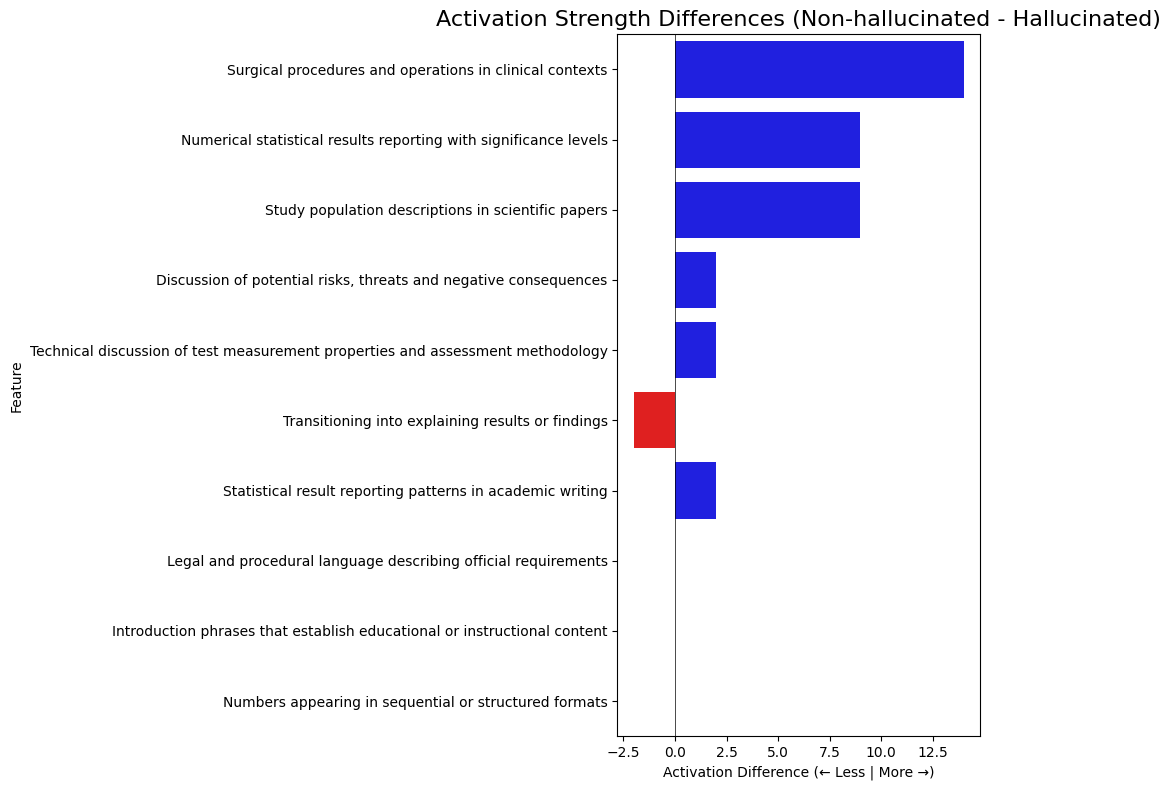


Comparison Statistics:
Total features: 10
Common features: 10
Unique to Inspector1: 0
Unique to Inspector2: 0


In [58]:
compare_feature_activation(inspector_hallucinated, inspector)   

C:\Users\samue\AppData\Local\Temp\ipykernel_21344\2137342849.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Activation', y='Feature', data=activation_df, palette='viridis')
C:\Users\samue\AppData\Local\Temp\ipykernel_21344\2137342849.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


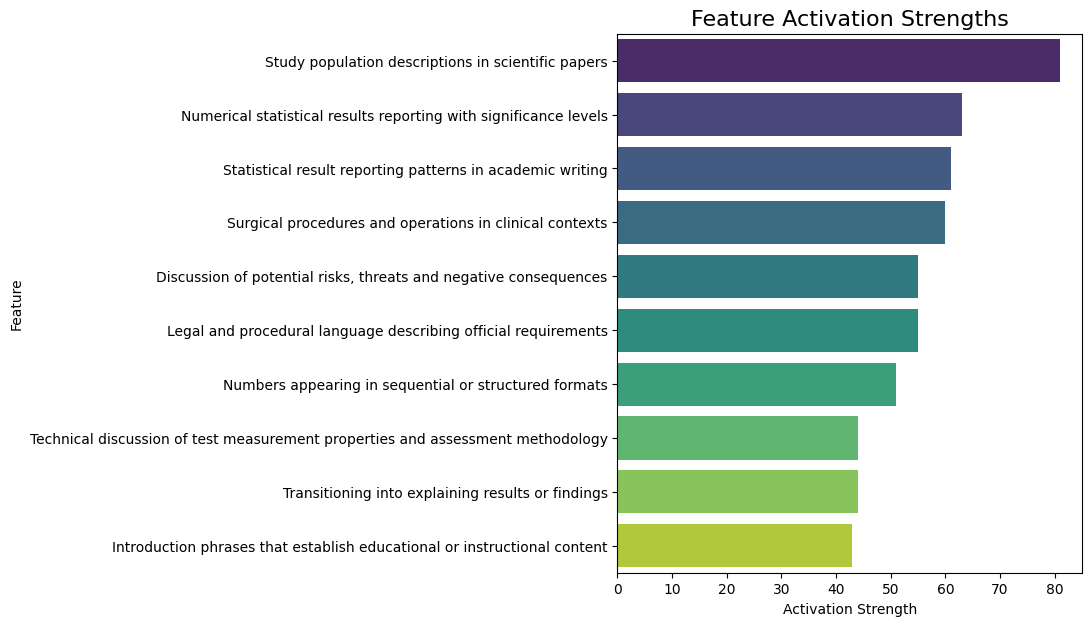

In [53]:
heatmap_plot(inspector_hallucinated)


C:\Users\samue\AppData\Local\Temp\ipykernel_21344\2137342849.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Activation', y='Feature', data=activation_df, palette='viridis')
C:\Users\samue\AppData\Local\Temp\ipykernel_21344\2137342849.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


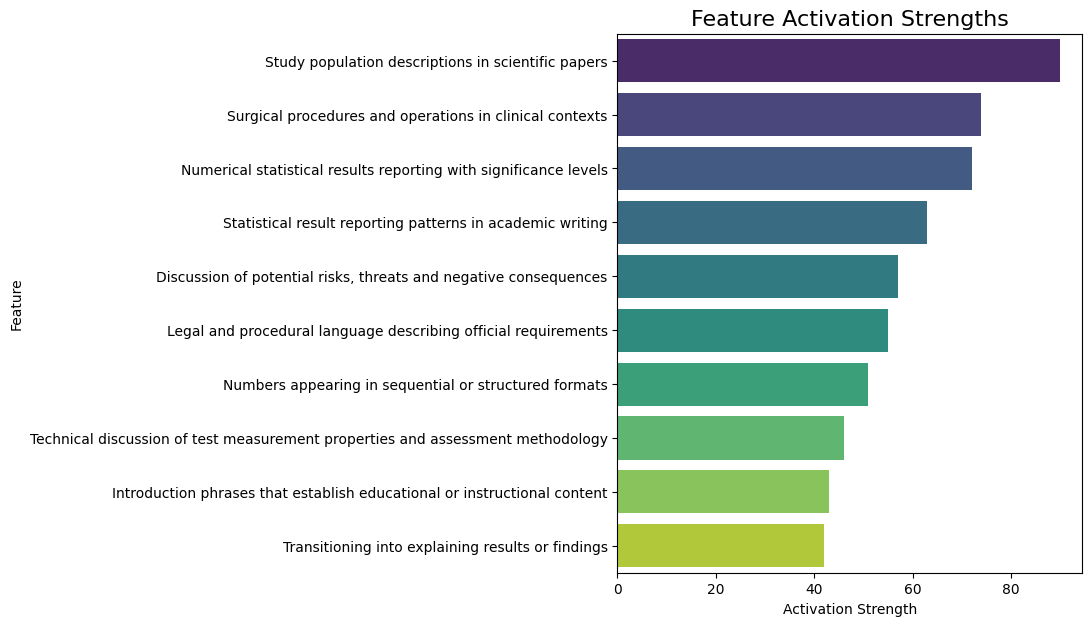

In [54]:
heatmap_plot(inspector)